---
author: "Ricardo Semião e Castro"
warning: false
message: false
format:
  pdf:
    toc: true
    toc-depth: 3
    number-sections: false
    include-in-header:
      text: |
        \usepackage{sectsty}
        \usepackage{etoolbox}
        \patchcmd{\tableofcontents}{\thispagestyle{plain}}{\thispagestyle{plain}\clearpage}{}{}
        \subsectionfont{\clearpage}
---

# Problem Set 3

## Setup

The files from this problem set can be found in [github.com/ricardo-semiao/task-masters -> quant-macro](https://github.com/ricardo-semiao/task-masters/tree/main/quant-macro).

Importing required libraries:

In [30]:
import numpy as np
import polars as pl

import plotnine as gg
from plotnine import ggplot, aes
gg.theme_set(gg.theme_bw())

And a custom function for pretty printing:

In [31]:
def pp(x, trans = float, n = 3):
    return trans(round(x, n))

In this problem set, we will deal with the Huggett (1993) model.

Lets define the parameters. Note that we need to transform the discount factor and interest rate from annual to bimestral terms.

In [32]:
np.random.seed(280419283)

n = 2 #number of states
states = [1, 0.1] #value of states (employed and unemployed)
probs = np.array([[0.925, 0.075], [0.5, 0.5]]) #transition matrix

beta = 0.96 ** (1 / 6) #discount factor
sigma = 1.5 #CRRA utility function parameter
r = (1 + 0.034) ** (1 / 6) - 1 #interest rate

m = 200 #number of grid points
tol = 1e-6 #tolerance level
max_iter = 1000 #maximum number of iterations

Now, we need the average income, to set the grid for the assets. We want the average income based on the unconditional probabilities of each state, so we need to solve the system defined by the transition matrix. In other terms, we need to get the normalized eigenvector associated with the eigenvalue 1, and use that as the weights for the incomes. That calculation is done below.

In [33]:
eigvals, eigvecs = np.linalg.eig(probs.T)
stationary = eigvecs[:, np.isclose(eigvals, 1)].flatten()
income_avg = np.dot(stationary / stationary.sum(), states)

Now, we can define the grid:

In [34]:
a_grid = np.linspace(-income_avg, 3 * income_avg, m)

## 1.a) Optimal Decision Rules

In this question, my interpretation was that the goal is to find the policy function for the assets. Below, I'll present the algorithm and the code that applies it. This is in line with the TA's solution of 15/9.

### Utility Functions

Our algorithm works as follows:

1. We set placeholders for the value function and optimal policy function.
2. We create the grid for consumption based on the grid for assets, and then, the grid for utility based on consumption.
3. We start the iteration:
    - Calculating the expected value of the value function.
    - Calculating the new VF, using the utility grid.
    - We find the maximum VF, and set it as the VF for the next operation, and store the related policy function.
    - If the change between the old and new VF is smaller than the tolerance, we stop the iteration.

First, the functions for the grids of consumption and utility:

In [35]:
def get_c_and_u(states, a_grid, r, sigma, tol = 1e-10):
    cs = [None, None]
    us = [None, None]

    for i in range(2):
        cs[i] = np.maximum((1 + r) * a_grid[:, np.newaxis] + states[i] - a_grid, tol)
        us[i] = (cs[i]**(1 - sigma) - 1) / (1 - sigma)

    return cs, us

And then, the actual iteration:

In [36]:
def value_function(
        states, a_grid, r, probs, beta, sigma,
        m, n,
        tol = tol, max_iter = max_iter, silent = True):
    vs = np.zeros((m, n))
    vs_new = np.zeros((m, n))
    a_policy = np.zeros((m, n))

    cs, us = get_c_and_u(states, a_grid, r, sigma)

    for iter in range(max_iter):
        vs_expected = beta * np.dot(vs, probs.T)

        for i in range(2):
            v_new = us[i] + vs_expected[:, i]
            vs_new[:, i] = np.max(v_new, axis = 1)
            a_policy[:, i] = a_grid[np.argmax(v_new, axis = 1)]
    
        cond = all([np.max(np.abs(vs_new[:, i] - vs[:, i])) < tol for i in range(2)])
        vs = vs_new.copy()
        if cond: break

    if iter + 1 == 1000 and not silent:
        print('Hit maximum amount of iterations on distribution step')    

    return a_policy

### Results

Now, we can run the function, and plot the results.

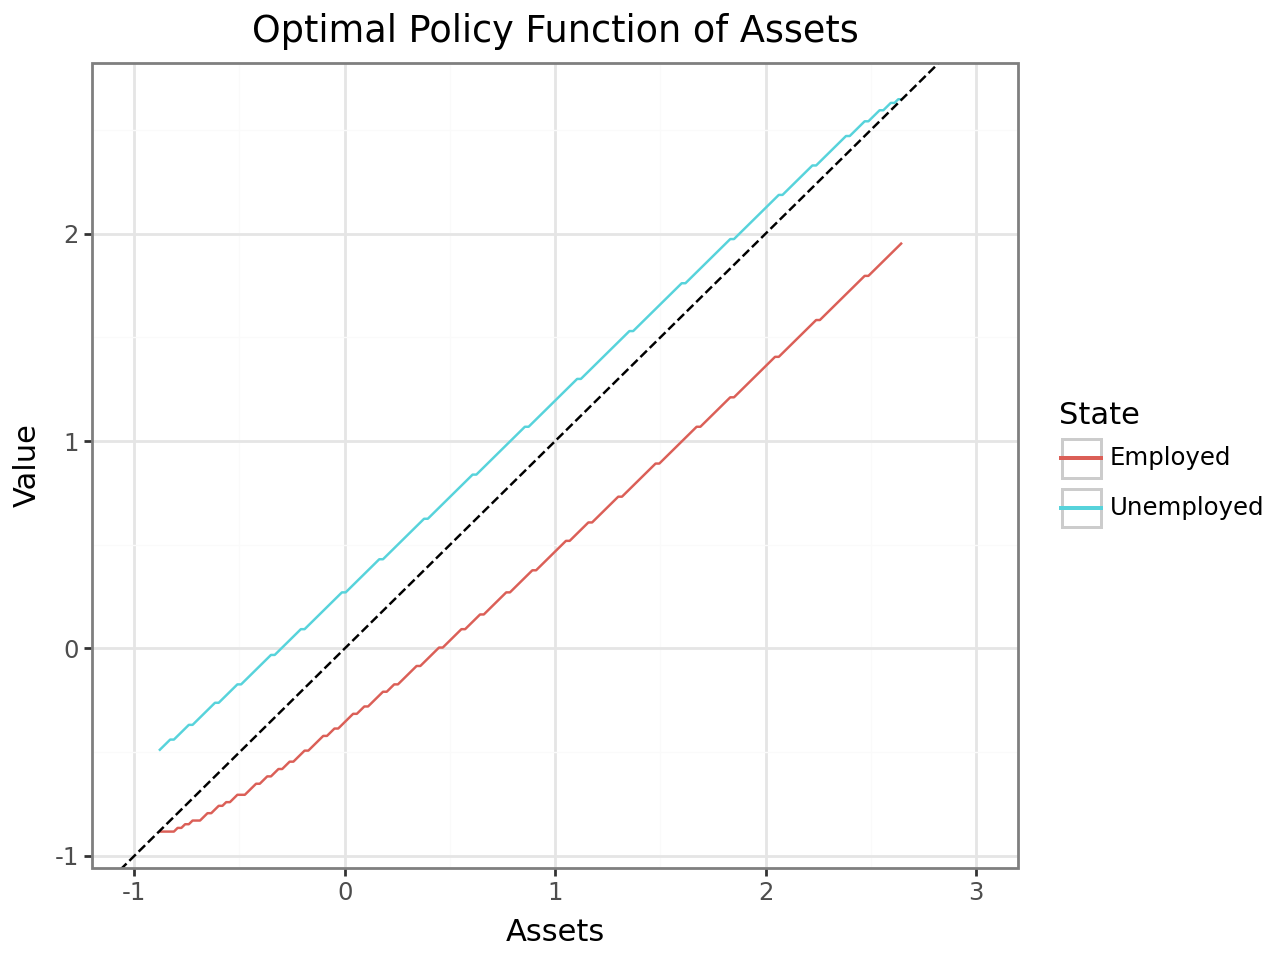

In [37]:
a_policy = value_function(states, a_grid, r, probs, beta, sigma, m, n)

data_policy = pl.DataFrame({
    'Assets': a_grid,
    'Employed': a_policy[:, 1],
    'Unemployed': a_policy[:, 0]
}).unpivot(
    index = 'Assets', on = ['Employed', 'Unemployed'],
    variable_name = 'State', value_name = 'Value'
)

(
    ggplot(data_policy, aes('Assets', 'Value', color = 'State'))
    + gg.geom_line()
    + gg.geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
    + gg.xlim(-1, 3)
    + gg.labs(title = "Optimal Policy Function of Assets")
)

### Stationary Distribution

The question did not necessarily asked for the distribution of assets. As we will need it later, I also calculated it here.

We need to create the Markov chains and update the distribution. Here are functions for that.

In [38]:
def markov(a_policy, probs, n, m):
    mkprobs_aux = [None, None]
    mkprobs = np.zeros((n * m, n * m))

    for i in range(m):
        for j in range(m):
            mkprobs[i*2, 2*j] = probs[0, 0] * (a_policy[i, 0] == a_grid[j])
            mkprobs[i*2, 2*j+1] = probs[0, 1] * (a_policy[i, 0] == a_grid[j])
            mkprobs[i*2+1, 2*j] = probs[1, 0] * (a_policy[i, 1] == a_grid[j])
            mkprobs[i*2+1, 2*j+1] = probs[1, 1] * (a_policy[i, 1] == a_grid[j])

    return mkprobs

In [39]:
def distribution(mkprobs, n, m, tol = 1e-6, max_iter = 1000, silent = True):
    dist_prev = np.ones((n * m)) / (n * m)
    dist = dist_prev @ mkprobs
    iter_dist = 1
    
    for iter in range(max_iter):
        if np.linalg.norm(dist - dist_prev) < tol:
            break
        dist_prev = dist
        dist = np.matmul(dist, mkprobs)

    if iter + 1 == 1000 and not silent:
        print('Hit maximum amount of iterations on distribution step')

    return dist

Now, we can apply them to find and plot the stationary distribution.

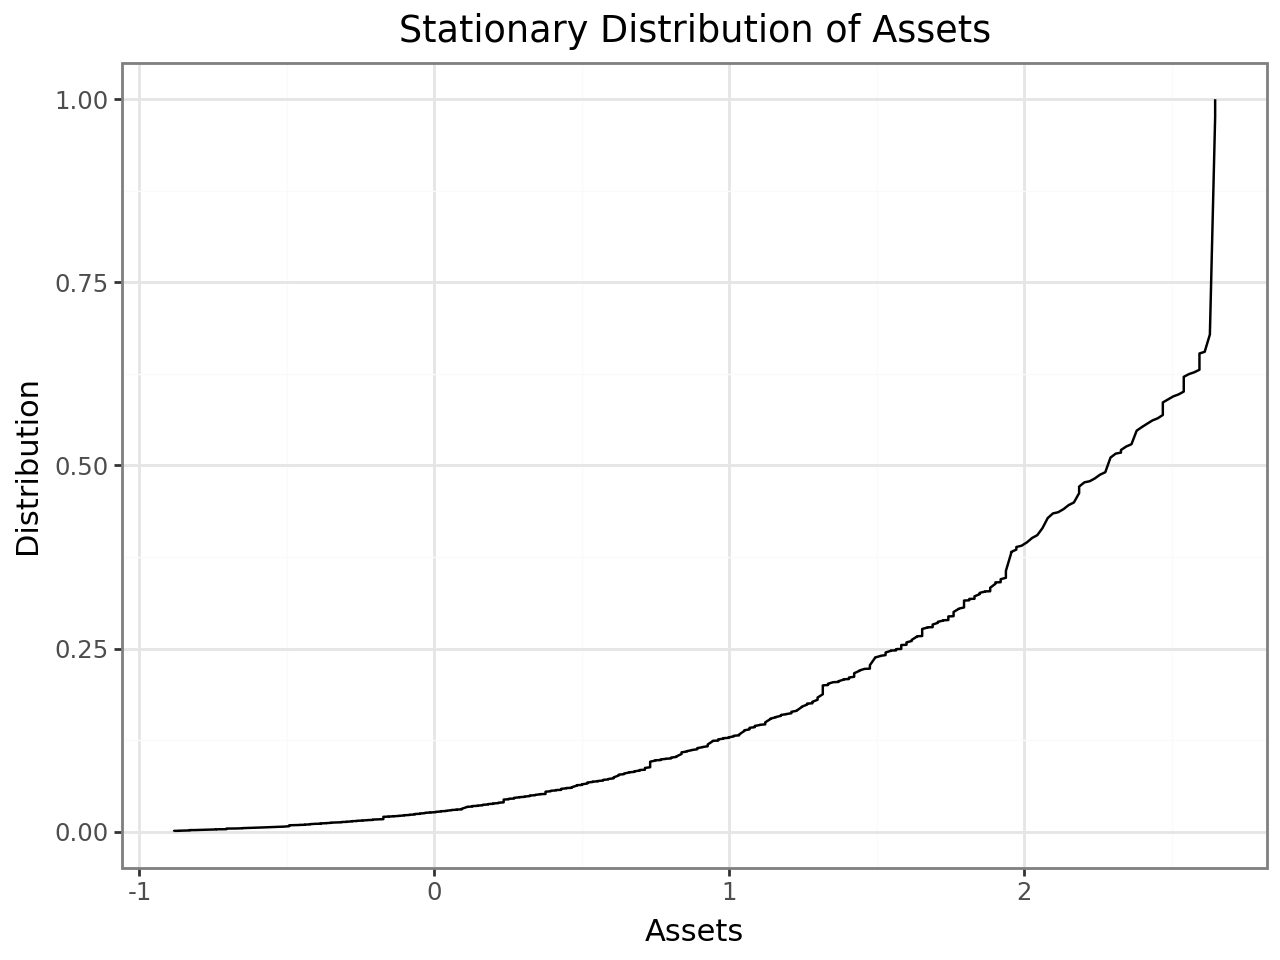

In [40]:
mkprobs = markov(a_policy, probs, n, m)
i_mat = distribution(mkprobs, n, m)

a_policy_flat = a_policy.flatten()

data_dist = pl.DataFrame({
    'Assets': a_policy_flat[np.argsort(a_policy_flat)],
    'Distribution': np.cumsum(i_mat[np.argsort(a_policy_flat)])
})

(
    ggplot(data_dist, aes('Assets', 'Distribution'))
    + gg.geom_line()
    + gg.labs(title = "Stationary Distribution of Assets")
)

### Other Interpretations

As I said, my interpretation to the goal of the item was the policy function for assets. But, another possible goal would be to find the optimal choice for consumption too. While I did not did that, I'll briefly explain the algorithm to accomplish it:

1. Use the same grids as before.
2. Initialize placeholders for the value function and optimal policies of assets and consumption.
3. Start a iteration of the value function.
4. For each state, do a iteration of each grid element (`1:m`) that is, each iteration is a level of assets.
    - For state of assets, iterate again on each grid element (`1:m`), for the level of future assets.
    - Define the consumption as the income (based on the state), plus interest, minus the future assets.
    - Calculate the utility of that consumption. And save it.
5. The iteration above that yielded the highest consumption is the one related to the (optimal) policy functions of assets and consumption.

## 1.b) Evolution of Wealth

Now, in this item, we will need to find the optimal choices of consumption. Thus, I'll use a similar algorithm as proposed in the previous subsection, but with some simplifications, as the focus is on the passage of the periods.

First, lets define some parameters:

In [41]:
periods = 10000

### Utility Functions

Lets create a function to run the algorithm.

In [42]:
def get_series(periods, a_policy, a_grid, states, probs, r):
    assets = np.zeros(periods)
    income = np.zeros(periods)

    a_series = np.zeros(periods)
    c_series = np.zeros(periods)
    state_series = np.zeros(periods, dtype = int)

    for t in range(periods - 1):
        acur = a_series[t]
        scur = state_series[t]

        a_series[t] = acur
        income[t] = scur
    
        a_future = a_policy[min(np.searchsorted(a_grid, acur), m - 1), scur]
        scur = np.random.choice([0, 1], p = probs[scur])
    
        c_series[t + 1] = (1 + r) * acur + states[scur] - a_future
        a_series[t + 1] = a_future
        state_series[t + 1] = scur
    
    return a_series, c_series, state_series

### Results

Now, we can run the iteration for each period, and plot the results

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 33'. Pick better value with 'binwidth'.


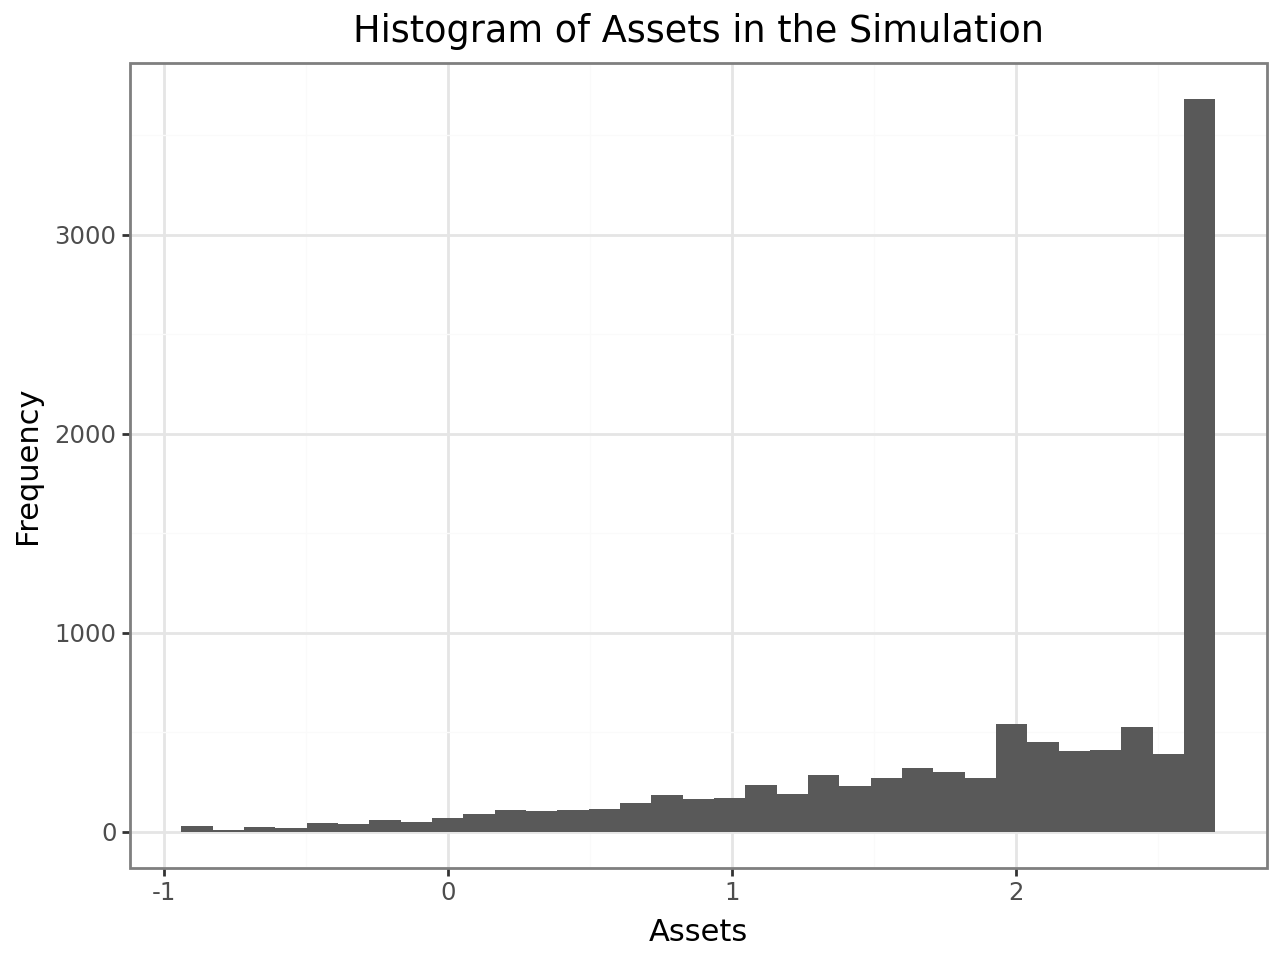

In [43]:
a_series, c_series, state_series = \
    get_series(periods, a_policy, a_grid, states, probs, r)

(
    ggplot(pl.DataFrame({'Assets': a_series}), aes(x = 'Assets'))
    + gg.geom_histogram()
    + gg.labs(title = "Histogram of Assets in the Simulation", y = "Frequency")
)

## 1.c)

In this question all the results are saved in order in the `results` dictionary. After slicing the relevant part of the variables, with a (generator expression), the operations are:

1. Calculate the mean of the assets.
2. Get the first difference of the states, and check where it was equal to `1` (from employed to unemployed), and use it to calculate the difference in consumption.
3. Get the moments of employment and unemployment with `state_series_l == 0`, and the moments of 5 times unemployment with `np.cumsum(state_series_l) >= 5`.
4. Calculate the correlations.

In [44]:
a_series_l, c_series_l, state_series_l = \
    (x[-1000:] for x in (a_series, c_series, state_series))

results = {}

results['Assets average'] = pp(a_series_l.mean())

ind1 = np.where(np.diff(state_series_l, prepend = 0) == 1)[0]
results['Consumption decrease'] = pp((c_series_l[ind1 - 1] - c_series_l[ind1]).mean())

ind2 = np.where(state_series_l == 0)[0]
results['Consumption averages'] = (
    pp(c_series_l[ind2].mean()),
    pp(c_series_l[-ind2].mean()),
    pp(c_series_l[np.cumsum(state_series_l) >= 5].mean())
)

results['Correlations'] = (
    pp(np.corrcoef(a_series_l, c_series_l)[0, 1]),
    pp(np.corrcoef(a_series_l, state_series_l)[0, 1]),
    pp(np.corrcoef(c_series_l, state_series_l)[0, 1])
)

results

{'Assets average': 1.937,
 'Consumption decrease': 0.961,
 'Consumption averages': (0.97, 0.891, 0.885),
 'Correlations': (0.091, -0.2, -0.674)}

## 1.d)

### Market Clearing Rate

To find the market clearing rate, we will need to:

1. Run the value function iteration to get the policy function for assets, and the stationary distribution.
2. With both of these, we can calculate the average aggregate assets.
3. Use that knowledge to fuel a bisection algorithm: set bounds for the interest rate, and iterate, reducing the upper or lower bound -- based on the sign of the average aggregate assets -- until we find a rate that clears the market, up to some tolerance.

Lets create a function for this:

In [45]:
def get_market_r(a_grid, sigma):
    r_bounds = np.array([-0.2, 0])

    while r_bounds[1] - r_bounds[0] > 1e-10:
        r_mid = np.mean(r_bounds)
        
        a_policy = value_function(states, a_grid, r_mid, probs, beta, sigma, m, n)
        mkprobs = markov(a_policy, probs, n, m)
        i_mat = distribution(mkprobs, n, m)
    
        a_mean = np.sum(i_mat[:m] * a_grid) + np.sum(i_mat[m:] * a_grid)
        
        if a_mean > 0:
            r_bounds[1] = r_mid
        else:
            r_bounds[0] = r_mid
    
    a_std = np.sqrt(
        np.sum(i_mat[:m] * (a_grid - a_mean) ** 2) +\
            np.sum(i_mat[m:] * (a_grid - a_mean) ** 2)
    )
    
    return r_mid, a_mean, a_std

The results are:

In [46]:
r_mid, a_mean, a_std = get_market_r(a_grid, sigma)

print(f'Market clearing rate: {round(r_mid, 5) * 100}%')
f'Average assets with market clearing rate: {round(a_mean, 4) * 100} ({round(a_std, 4)})'

Market clearing rate: -11.537%


'Average assets with market clearing rate: -0.3 (0.3317)'

We have a negative interest rate, which is a counter-intuitive result. It might be explained by the preferences over future consumption of the agents, but it possibly is a not founded mistake in the code.

The interpretation of the results below is troubled, but I created the functions to work with a "correct" result too, and did the interpretations assuming the "weird" result.

### Items b) and c)

We can re-do our calculations, but with the new rate, `r_mid`.

The histogram:

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 36'. Pick better value with 'binwidth'.


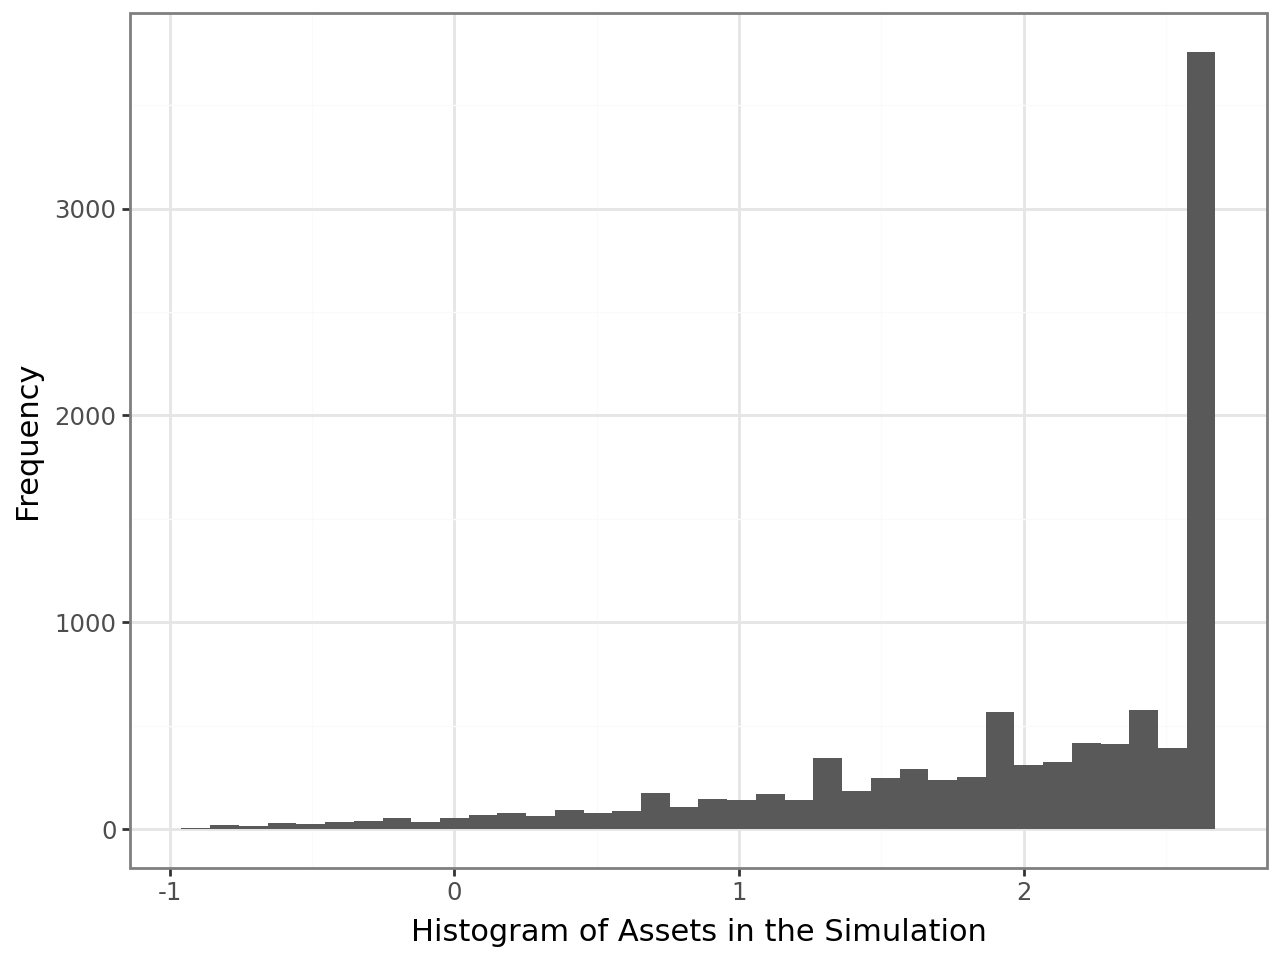

In [48]:
a_series, c_series, state_series = \
    get_series(periods, a_policy, a_grid, states, probs, r_mid)

(
    ggplot(pl.DataFrame({'Assets': a_series}), aes(x = 'Assets'))
    + gg.geom_histogram()
    + gg.labs("Histogram of Assets in the Simulation", y = "Frequency")
)

And the descriptive statistics from item c):

In [49]:
a_series_l, c_series_l, state_series_l = \
    (x[-1000:] for x in (a_series, c_series, state_series))

results = {}

results['Assets average'] = pp(a_series_l.mean())

ind1 = np.where(np.diff(state_series_l, prepend = 0) == 1)[0]
results['Consumption decrease'] = pp((c_series_l[ind1 - 1] - c_series_l[ind1]).mean())

ind2 = np.where(state_series_l == 0)[0]
results['Consumption averages'] = (
    pp(c_series_l[ind2].mean()),
    pp(c_series_l[-ind2].mean()),
    pp(c_series_l[np.cumsum(state_series_l) >= 5].mean())
)

results['Correlations'] = (
    pp(np.corrcoef(a_series_l, c_series_l)[0, 1]),
    pp(np.corrcoef(a_series_l, state_series_l)[0, 1]),
    pp(np.corrcoef(c_series_l, state_series_l)[0, 1])
)

results

{'Assets average': 2.106,
 'Consumption decrease': 0.937,
 'Consumption averages': (0.724, 0.653, 0.657),
 'Correlations': (-0.184, -0.223, -0.676)}

## 1.e)

Lets change the parameter and get the results.

In [50]:
sigma2 = 3

We can see the new clearing rate, and the new moments:

In [51]:
r_mid, a_mean, a_std = get_market_r(a_grid, sigma2)

print(f'Market clearing rate: {round(r_mid, 5) * 100}%')
f'Average assets with market clearing rate: {round(a_mean, 4) * 100} ({round(a_std, 4)})'

Market clearing rate: -20.0%


'Average assets with market clearing rate: 51.29 (0.4823)'

We can see that the interest rate got even lower, which could be interpreted in terms of the change of smoothing preferences of the agents. Still, it is a weird result.

Besides the std. deviation seen above, we can also calculate the Gini coefficient:

In [65]:
a_sorted = np.sort(a_grid.flatten())

gini = (2 * np.sum((np.arange(1, m + 1) * a_sorted))) / \
    (n * np.sum(a_sorted)) - (m + 1) / m

f'Gini coefficient: {round(gini, 4) / 10}%'

'Gini coefficient: 16.6495%'

At face value, we can see that the standard deviation increased, from $0.3317$ to $0.4823$, which implies a higher variance in the distribution of assets. The Gini coefficient will be compared in the next question.

## 1.f)

The halving of the borrowing constraint can be represented by a new grid of assets.

Note that I assumed the higher `sigma` of $3$ as still in place for this question.

In [60]:
a_grid2 = np.linspace(-income_avg / 2, 3 * income_avg, m)

Now, we can get the updated results:

In [61]:
r_mid, a_mean, a_std = get_market_r(a_grid2, sigma2)

print(f'Market clearing rate: {round(r_mid, 5) * 100}%')
f'Average assets with market clearing rate: {round(a_mean, 4) * 100} ({round(a_std, 4)})'

Market clearing rate: -4.8%


'Average assets with market clearing rate: 0.0 (0.0)'

Besides the std. deviation seen above, we can also calculate the Gini coefficient:

In [66]:
a_sorted = np.sort(a_grid2.flatten())

gini = (2 * np.sum((np.arange(1, m + 1) * a_sorted))) / \
    (n * np.sum(a_sorted)) - (m + 1) / m

f'Gini coefficient: {round(gini, 4) / 10}%'

'Gini coefficient: 14.639500000000002%'

We can see that the market rate is strongly increased.

More significantly, we see that, with a more relaxed constraint: the standard deviation decreased, and society moved into a more equal distribution, as the Gini coefficient decreased.